In [ ]:
from google.colab import files
files.upload()


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
! kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 98% 761M/778M [00:04<00:00, 193MB/s]
100% 778M/778M [00:04<00:00, 195MB/s]


In [ ]:
! unzip "/content/covid19-radiography-database.zip"

In [ ]:
from tensorflow.keras import *
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
base_dir = '/content/COVID-19_Radiography_Dataset'
os.listdir(base_dir)

['Normal',
 'Lung_Opacity',
 'README.md.txt',
 'Viral Pneumonia.metadata.xlsx',
 'Viral Pneumonia',
 'COVID.metadata.xlsx',
 'Normal.metadata.xlsx',
 'COVID',
 'Lung_Opacity.metadata.xlsx']

In [ ]:
imagens_normal = '/content/COVID-19_Radiography_Dataset/Normal/images'
imagens_covid = '/content/COVID-19_Radiography_Dataset/COVID/images'
imagens_pneu = '/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images'


In [ ]:
print(len(os.listdir(imagens_normal)))
print(len(os.listdir(imagens_covid)))
print(len(os.listdir(imagens_pneu)))


10192
3616
1345


In [ ]:
covid_image_list = os.listdir(imagens_normal)
normal_image_list = os.listdir(imagens_covid)
pneu_image_list = os.listdir(imagens_pneu)

In [ ]:
paths = []
y = []

for dirname, _, filenames in os.walk('/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            paths.append(os.path.join(dirname, filename))
            y.append(0)
for dirname, _, filenames in os.walk('/content/COVID-19_Radiography_Dataset/Normal/images'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            paths.append(os.path.join(dirname, filename))
            y.append(1)   
for dirname, _, filenames in os.walk('/content/COVID-19_Radiography_Dataset/COVID/images'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            paths.append(os.path.join(dirname, filename))
            y.append(2)

In [ ]:
len(paths)

15153

In [ ]:
len(y)

15153

In [ ]:
X = []
for i in paths:
    image = cv2.imread(i)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (128, 128))

    X.append(image)

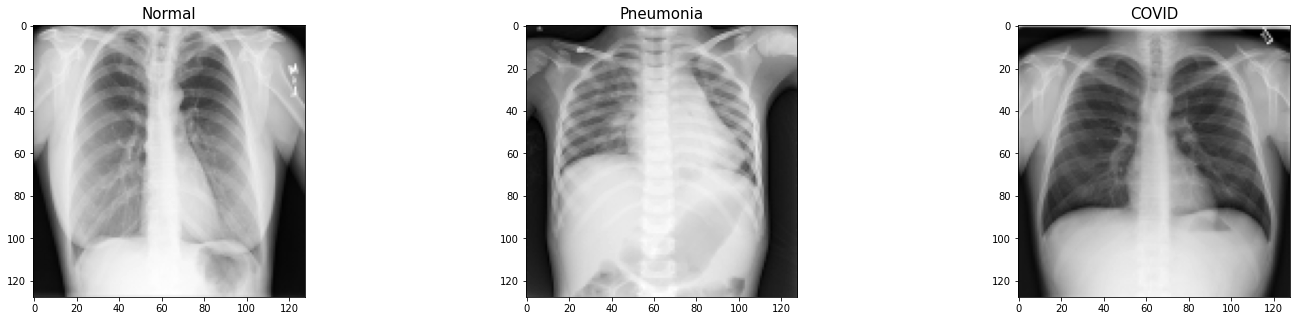

In [ ]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols = 3,nrows = 1, figsize = (25,5))
ax1.imshow(X[1500],cmap='gray')
ax2.imshow(X[0],cmap='gray')
ax3.imshow(X[2900],cmap='gray')

ax1.set_title('Normal',fontsize=15)
ax2.set_title('Pneumonia',fontsize=15)
ax3.set_title('COVID',fontsize=15)

plt.show()

In [ ]:
X = np.array(X)/255
y = np.array(y)


In [ ]:
X = X.reshape(-1,128,128,1)

In [ ]:
X.shape

(15153, 128, 128, 1)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
Xtrain, Xval, ytrain, yval  = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [ ]:
ycat_val = to_categorical(yval,3)
ycat_train = to_categorical(ytrain,3)

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(128,128,1), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(128,128,1), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(126))

model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 64)        0

In [ ]:

image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               zoom_range=0.05, # Zoom in by 5% max
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )
image_gen.fit(Xtrain)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=20)

In [ ]:
results = model.fit_generator(image_gen.flow(Xtrain, ycat_train), epochs=40,validation_data=(Xval,ycat_val), callbacks = [early_stop])


<ipython-input-31-f49418d551f2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(image_gen.flow(Xtrain, ycat_train), epochs=40,validation_data=(Xval,ycat_val), callbacks = [early_stop])


Epoch 1/40
356/356 [==============================] - 300s 840ms/step - loss: 0.6544 - accuracy: 0.7108 - val_loss: 0.5047 - val_accuracy: 0.7762
Epoch 2/40
356/356 [==============================] - 297s 835ms/step - loss: 0.4772 - accuracy: 0.7884 - val_loss: 0.3891 - val_accuracy: 0.8348
Epoch 3/40
356/356 [==============================] - 299s 840ms/step - loss: 0.4071 - accuracy: 0.8234 - val_loss: 0.3948 - val_accuracy: 0.8511
Epoch 4/40
356/356 [==============================] - 300s 842ms/step - loss: 0.3660 - accuracy: 0.8463 - val_loss: 0.3476 - val_accuracy: 0.8657
Epoch 5/40
356/356 [==============================] - 297s 835ms/step - loss: 0.3510 - accuracy: 0.8525 - val_loss: 0.3136 - val_accuracy: 0.8873
Epoch 6/40
356/356 [==============================] - 298s 837ms/step - loss: 0.3372 - accuracy: 0.8595 - val_loss: 0.2997 - val_accuracy: 0.8889
Epoch 7/40
356/356 [==============================] - 296s 832ms/step - loss: 0.3216 - accuracy: 0.8675 - val_loss: 0.2772 -

In [ ]:
model.metrics_names


['loss', 'accuracy']

In [ ]:
losses = pd.DataFrame(model.history.history)

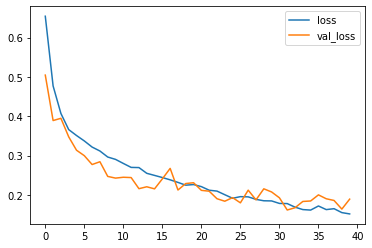

In [ ]:

losses[['loss','val_loss']].plot()
plt.show()

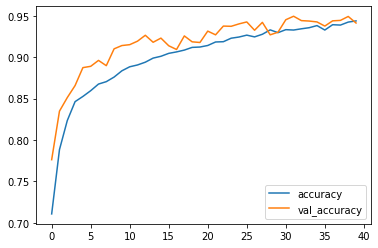

In [ ]:
losses[['accuracy','val_accuracy']].plot()
plt.show()

In [ ]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.1 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import os
import random 
from shutil import copyfile
import pydicom as dicom
import cv2
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import backend as K 
K.set_image_data_format('channels_last')

In [ ]:
predict_x=model.predict(Xval) 
classes_x=np.argmax(predict_x,axis=1)

119/119 [==============================] - 22s 181ms/step


In [ ]:
# 0: Pneumonia
# 1: Normal
# 2: COVID-19

from sklearn.metrics import classification_report
print(classification_report(yval,classes_x))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       337
           1       0.94      0.98      0.96      2581
           2       0.95      0.85      0.89       871

    accuracy                           0.94      3789
   macro avg       0.93      0.92      0.92      3789
weighted avg       0.94      0.94      0.94      3789



In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(yval,classes_x)

array([[ 313,   21,    3],
       [  27, 2517,   37],
       [   8,  127,  736]])

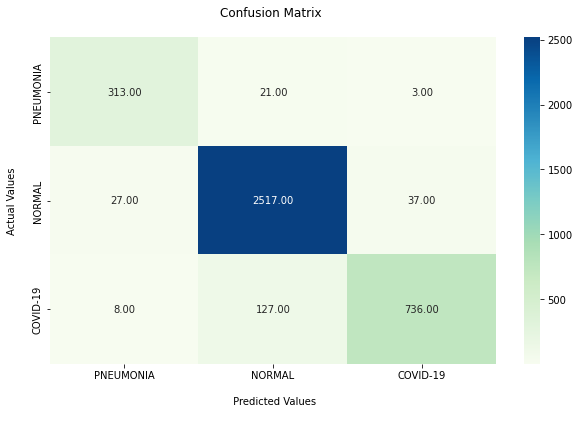

In [ ]:
plt.figure(figsize=(10,6))
import seaborn as sns
fx= sns.heatmap(confusion_matrix(yval,classes_x), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['PNEUMONIA','NORMAL','COVID-19'])
fx.yaxis.set_ticklabels(['PNEUMONIA','NORMAL','COVID-19'])
plt.show()